In [144]:
from fastai.vision.all import *
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

In [145]:
train_df = pd.read_csv('./Dataset/fairface_label_train.csv').drop(columns=['service_test'])
val_df = pd.read_csv('./Dataset/fairface_label_val.csv').drop(columns=['service_test']) 

train_df = train_df.sample(n=15000, random_state=42).reset_index(drop=True)
val_df = val_df.sample(n=1000, random_state=42).reset_index(drop=True)  

In [146]:
print(train_df.head(), '\n')
print(val_df.head())

              file    age  gender            race
0  train/47414.jpg  20-29    Male  Middle Eastern
1  train/52264.jpg  30-39    Male  Middle Eastern
2  train/21584.jpg  10-19  Female          Indian
3  train/32130.jpg  30-39    Male           Black
4  train/63301.jpg  10-19    Male          Indian 

           file    age  gender             race
0  val/5413.jpg  10-19    Male  Latino_Hispanic
1   val/901.jpg  30-39  Female   Middle Eastern
2  val/2406.jpg  20-29  Female  Latino_Hispanic
3  val/2175.jpg    3-9  Female       East Asian
4  val/7699.jpg  30-39  Female  Latino_Hispanic


In [147]:
age_labels = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']
gender_labels = ['Male', 'Female']
race_labels = ['White', 'Black', 'East Asian', 'Southeast Asian', 'Indian', 'Middle Eastern', 'Latino_Hispanic']


# Define encoding functions
def encode_age(age):
    mlb_age = MultiLabelBinarizer(classes=age_labels)
    return mlb_age.fit_transform([[age]]).flatten()

def encode_gender(gender):
    mlb_gender = MultiLabelBinarizer(classes=gender_labels)
    return mlb_gender.fit_transform([[gender]]).flatten()

def encode_race(race):
    mlb_race = MultiLabelBinarizer(classes=race_labels)
    return mlb_race.fit_transform([[race]]).flatten()

# Define function to apply encoding to each row
def encode_labels(row):
    return np.concatenate([
        encode_age(row['age']),
        encode_gender(row['gender']),
        encode_race(row['race'])
    ])
    
# Define function to apply encoding to each row
def encode_labels(row):
    return np.concatenate([
        encode_age(row['age']),
        encode_gender(row['gender']),
        encode_race(row['race'])
    ])
    
# Apply encoding function to the DataFrame
train_df['encoded_labels'] = train_df.apply(encode_labels, axis=1)
val_df['encoded_labels'] = val_df.apply(encode_labels, axis=1)

In [148]:
def get_labels(row):
    return row['age'], row['gender'], row['race']

fairface_block = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),   
    get_x=ColReader('file', pref='./Dataset/'),                   
    get_y=ColReader(['age', 'gender', 'race']), 
    splitter=RandomSplitter(seed=42),          
    item_tfms=Resize(224),                     
    batch_tfms=aug_transforms(mult=1.0)       
)

dls = fairface_block.dataloaders(train_df, bs=64)

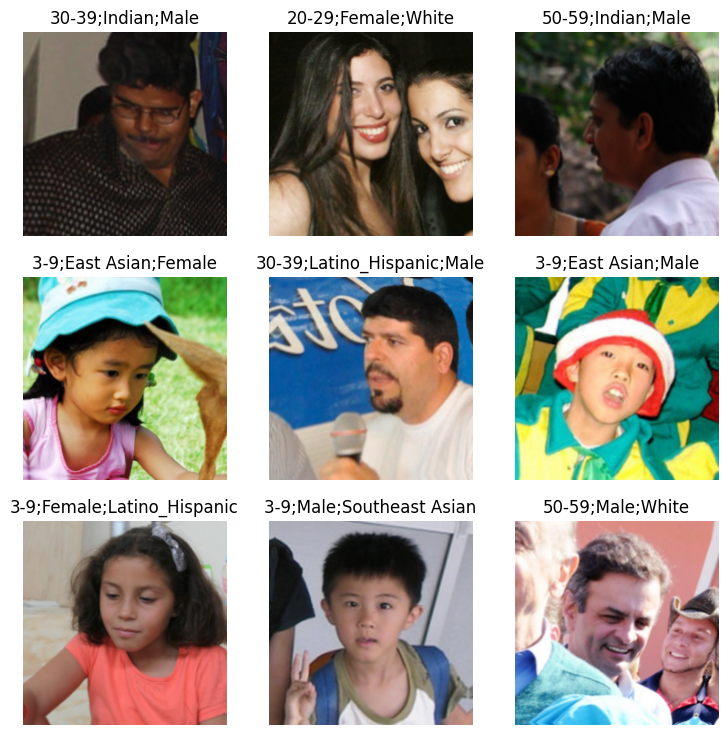

In [149]:
dls.show_batch()

In [150]:
learn = vision_learner(dls, resnet34, metrics=[accuracy_multi])  

In [151]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [152]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.559676,0.344483,0.864481,01:00


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.344934,0.296379,0.879759,01:21
1,0.298822,0.275239,0.886148,01:21
2,0.267332,0.254587,0.891296,01:22
3,0.238497,0.241200,0.896574,01:22
4,0.218637,0.234291,0.899537,01:23
5,0.195674,0.239683,0.899445,01:23
6,0.172381,0.237574,0.899926,01:23
7,0.151790,0.239350,0.900296,01:23
8,0.138084,0.243032,0.900222,01:23
9,0.130797,0.243251,0.900000,01:23


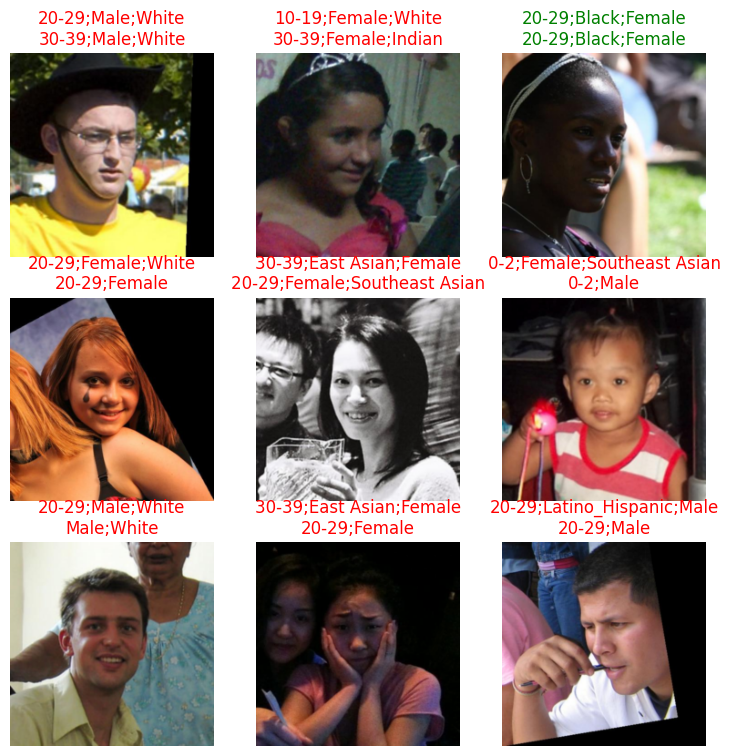

In [153]:
learn.show_results()

In [156]:
img = PILImage.create('./Dataset/val/666.jpg')
pred, pred_idx, probs = learn.predict(img)

age_probs = probs[:len(age_labels)]
gender_probs = probs[len(age_labels):len(age_labels) + len(gender_labels)]
race_probs = probs[len(age_labels) + len(gender_labels):]

print("Age Category Probabilities:")
for label, prob in zip(age_labels, age_probs):
    print(f'{label}: {prob:.4f}')

print("\nGender Category Probabilities:")
for label, prob in zip(gender_labels, gender_probs):
    print(f'{label}: {prob:.4f}')

print("\nRace Category Probabilities:")
for label, prob in zip(race_labels, race_probs):
    print(f'{label}: {prob:.4f}')

Age Category Probabilities:
0-2: 0.0009
3-9: 0.6168
10-19: 0.3088
20-29: 0.0139
30-39: 0.1959
40-49: 0.1057
50-59: 0.0101
60-69: 0.0051
more than 70: 0.8183

Gender Category Probabilities:
Male: 0.0005
Female: 0.9103

Race Category Probabilities:
White: 0.0593
Black: 0.0736
East Asian: 0.0906
Southeast Asian: 0.0122
Indian: 0.0069
Middle Eastern: 0.0037
Latino_Hispanic: 0.0003
